In [1]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import fontManager

#Colab 進行matplotlib繪圖時顯示繁體中文
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud


--2023-09-13 19:54:23--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.218.113, 173.194.218.102, 173.194.218.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.218.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c8q1u2bjl5uecffmrq9e4cede2jdt3bs/1694634825000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=0701715d-ae50-4d73-b17b-2309c95d1215 [following]
--2023-09-13 19:54:27--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c8q1u2bjl5uecffmrq9e4cede2jdt3bs/1694634825000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=0701715d-ae50-4d73-b17b-2309c95d1215
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 108.177.13.132, 2607:f8b0:400c:c09::84
Connecting to do

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
API_KEY = 'Input your API key here'

In [3]:
channel_ids = ['UCvTe3Z7TZsjGzUERx4Ce6zA',
        'UCEtw3BDrzbo6x2aFCEiEqfw',
        'UCFUtqTcgJgRnmZ3tMU6P74Q'
        # more channels here
        ]
#To get the channel id, you can use this link: https://commentpicker.com/youtube-channel-id.php

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
  api_service_name, api_version, developerKey = API_KEY)

In [5]:
def get_channel_stats(youtube, channel_ids):

  all_data = []

  request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=",".join(channel_ids)
  )
  response = request.execute()

  # loop through items
  for item in response['items']:
      data = {'channelName': item['snippet']['title'],
            'subscribers': item['statistics']['subscriberCount'],
            'views': item['statistics']['viewCount'],
            'totalVideos': item['statistics']['videoCount'],
            'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
      }

      all_data.append(data)

  return pd.DataFrame(all_data)

In [6]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [7]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,攝徒日記Fun TV,794000,413460078,1398,UUvTe3Z7TZsjGzUERx4Ce6zA
1,Namewee,3530000,1669281636,1048,UUFUtqTcgJgRnmZ3tMU6P74Q
2,陳老師來了,414000,41163056,112,UUEtw3BDrzbo6x2aFCEiEqfw


In [8]:
playlistId="UUvTe3Z7TZsjGzUERx4Ce6zA"

def get_video_ids(youtube, playlist_id):

    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
    #因為maxResults只能最多提取50個Result，因此需要用while loop一直搜尋到最後一頁，獲取全部video id
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    return video_ids

In [9]:
video_ids = get_video_ids(youtube, playlistId)
len(video_ids)

1319

In [10]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    #因為API限制，一次最多只可以提取50個結果，所以for loop需要每50跳
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [11]:
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,VbU1n6ZS4pU,攝徒日記Fun TV,打臉華為發布會！小粉紅魔征嗆⋯大秀中國遙遙領先技術⋯不料Mate 60 Pro翻車了⋯,📺️頻道會員：https://www.youtube.com/channel/UCvTe3Z...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖, 華為mate 60 pro,...",2023-09-13T13:16:31Z,141210,8602,None,1891,PT11M3S,hd,true
1,HNkL18b_al0,攝徒日記Fun TV,中國五部恥度特輯！小粉紅尷尬秀⋯打倒特斯拉⋯月入三千超越台灣⋯台灣阿公入籍換中國護照⋯,📺️頻道會員：https://www.youtube.com/channel/UCvTe3Z...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖, 攝徒日記 小粉紅通話, 攝徒...",2023-09-12T13:16:53Z,315470,10037,None,2200,PT12M51S,hd,true
2,T8U1Dd2VupU,攝徒日記Fun TV,台灣人小眼睛，就是傷害中國人感情！ #shorts,📺️頻道會員：https://www.youtube.com/channel/UCvTe3Z...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖]",2023-09-12T11:41:45Z,37716,2467,None,322,PT44S,hd,false
3,lfuWJqhCJtU,攝徒日記Fun TV,中國老爹大鬧韓國！丟包小孩⋯稱希望孩子遠離中國；小粉紅逃票拍片炫耀⋯中國網紅穿唐裝⋯被誤認為...,中國爸爸花光積蓄，攜帶9歲小孩共遊韓國，便將其孩子丟包在韓國某座公園⋯並附上一封英文信表示：...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖, 攝徒日記 小粉紅通話, 攝徒...",2023-09-11T13:16:24Z,263145,11164,None,1502,PT10M41S,hd,true
4,u1rZSAQ1auM,攝徒日記Fun TV,愛國留學生大鬧日本！撿到錢包⋯要求存款20%為獎賞；中國網紅舉旗佔領沖繩嗆：不僅台灣是中國的...,一名在日本愛國留學生，近日在東京車站內撿到錢包，隨後送交站務人員，當下翻看內容物，發現裡面有...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖, 攝徒日記 小粉紅通話, 攝徒...",2023-09-10T12:46:25Z,330770,10620,None,2752,PT10M52S,hd,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,CdjbKWoLQT0,攝徒日記Fun TV,【花蓮旅遊攻略】花蓮景點｜新城村5大秘境｜立霧溪出海口比偶像劇場景還美,攝徒日記-89去旅行\n\n曼波魚的故鄉，新城村的獨家推薦\n往往大家所熟悉的新城只會想到七...,"[花蓮, 景點, 新城, 七星潭, 檸檬汁, 天主堂, 旅遊, vlog, 秘境, taiw...",2018-11-12T11:00:02Z,34462,339,None,28,PT4M53S,hd,false
1315,b3esFwRBLtY,攝徒日記Fun TV,【花蓮旅遊攻略】花蓮景點｜太魯閣白楊步道水濂洞 [Taiwan Travel ] Huali...,在太魯閣天祥山區不遠處的白楊步道水濂洞\n封閉1年多後，在10月28日重新開放\n夏天來到山...,"[太魯閣, 花蓮, 水濂洞, 白楊步道, 旅遊, 旅行, 秘境, hualien, taiw...",2018-11-06T12:00:05Z,10528,179,None,25,PT4M51S,hd,true
1316,Fdh52HvQBOo,攝徒日記Fun TV,花蓮活動｜2018太魯閣音樂祭｜多元民族共融,攝徒日記-89去旅行的主持人\n本身除了是道地的花蓮人之外\n更是太魯閣族的一員\n這次介紹...,"[太魯閣, 音樂祭, 花蓮, 台灣, VLOG, 旅遊, 旅行, 景點, 花蓮景點, 新城,...",2018-10-30T11:30:00Z,3250,110,None,25,PT5M1S,hd,false
1317,Wi7NAlypr0c,攝徒日記Fun TV,【花蓮旅遊攻略】花蓮景點｜屬於花蓮文青的博愛特區｜即將熄燈,攝徒日記-89去旅行\n\n趕在10/31結束營業前，來拍攝博愛特區\n紀錄他最後的美貌，給...,"[花蓮, 文青, 博愛特區, vlog, 旅遊, 景點, 花蓮景點, taiwan, hua...",2018-10-23T11:28:16Z,2988,89,None,10,PT1M20S,hd,false


In [12]:
def get_comments_in_videos(youtube, video_ids):
  """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:

    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs

    Returns:
    Dataframe with video IDs and associated top level comment in text.

  """
  all_comments = []

  for video_id in video_ids:
      try:
          request = youtube.commentThreads().list(
              part="snippet,replies",
              videoId=video_id
          )
          response = request.execute()

          comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
          comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

          all_comments.append(comments_in_video_info)

      except:
          # When error occurs - most likely because comments are disabled on a video
          print('Could not get comments for video ' + video_id)

  return pd.DataFrame(all_comments)

In [13]:
comment_df = get_comments_in_videos(youtube, video_ids)
comment_df

,video_id,comments
0,VbU1n6ZS4pU,[华为麒麟9000S是中芯国际国产光刻机产的，使用最先进的多重曝光技术，反复套刻制作的7纳米...
1,HNkL18b_al0,[中国国籍是全世界最难入的，一堆人排队都入不了，目前只有五个外国人拿到，李连杰退出中国籍后悔...
2,T8U1Dd2VupU,"[汗奸眼睛, 出來啊，下面怎麼沒見到任何一個死粉紅, 習豬頭微絲細眼也認真辱國，鼻大眼細丟中..."
3,lfuWJqhCJtU,[八迥，我最近没有闲钱可以去内蒙证明，但我可以保证ZG的铀煤开采是在合理和规的范围内，我下个...
4,u1rZSAQ1auM,"[煞比～我明天就前去內蒙正名\n吃一个鈾矿來看看！zg 沒有核汙, 看见你笑，我真的好想哭，..."
...,...,...
1314,CdjbKWoLQT0,"[讚👍, 可以看得出來你很愛你長大的地方，你的家，你的國，不然不會這樣的了解它，也帶著大家一..."
1315,b3esFwRBLtY,"[杞人憂天的牌子😂😂😂, 多拍個美好台灣的風景, 這裡是尚未遭受粉紅攻擊的淨土, 爬山穿皮衣..."
1316,Fdh52HvQBOo,"[狗杂种, 其實你媽根本不關心你啊😂, 酷，这些文化真的好棒，我妈妈是马来西亚的卡达山族的，..."
1317,Wi7NAlypr0c,"[哇嗚😃, 考古啦, 我們要獨立建國 台灣共和國 萬歲, 從旅遊美食節目變辱華節目, 辱華,..."


## Data pre-processing

In [14]:
video_df.isnull().any() #check for NULL values

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [15]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [16]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [17]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [18]:
pip install isodate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.1 MB/s eta 0:00:00


In [19]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [20]:
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,663.0,PT11M3S
1,771.0,PT12M51S
2,44.0,PT44S
3,641.0,PT10M41S
4,652.0,PT10M52S
...,...,...
1314,293.0,PT4M53S
1315,291.0,PT4M51S
1316,301.0,PT5M1S
1317,80.0,PT1M20S


In [21]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [22]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,VbU1n6ZS4pU,攝徒日記Fun TV,打臉華為發布會！小粉紅魔征嗆⋯大秀中國遙遙領先技術⋯不料Mate 60 Pro翻車了⋯,📺️頻道會員：https://www.youtube.com/channel/UCvTe3Z...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖, 華為mate 60 pro,...",2023-09-13 13:16:31+00:00,141210.0,8602.0,NaN,1891.0,PT11M3S,hd,true,Wednesday,663.0,38
1,HNkL18b_al0,攝徒日記Fun TV,中國五部恥度特輯！小粉紅尷尬秀⋯打倒特斯拉⋯月入三千超越台灣⋯台灣阿公入籍換中國護照⋯,📺️頻道會員：https://www.youtube.com/channel/UCvTe3Z...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖, 攝徒日記 小粉紅通話, 攝徒...",2023-09-12 13:16:53+00:00,315470.0,10037.0,NaN,2200.0,PT12M51S,hd,true,Tuesday,771.0,24
2,T8U1Dd2VupU,攝徒日記Fun TV,台灣人小眼睛，就是傷害中國人感情！ #shorts,📺️頻道會員：https://www.youtube.com/channel/UCvTe3Z...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖]",2023-09-12 11:41:45+00:00,37716.0,2467.0,NaN,322.0,PT44S,hd,false,Tuesday,44.0,7
3,lfuWJqhCJtU,攝徒日記Fun TV,中國老爹大鬧韓國！丟包小孩⋯稱希望孩子遠離中國；小粉紅逃票拍片炫耀⋯中國網紅穿唐裝⋯被誤認為...,中國爸爸花光積蓄，攜帶9歲小孩共遊韓國，便將其孩子丟包在韓國某座公園⋯並附上一封英文信表示：...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖, 攝徒日記 小粉紅通話, 攝徒...",2023-09-11 13:16:24+00:00,263145.0,11164.0,NaN,1502.0,PT10M41S,hd,true,Monday,641.0,30
4,u1rZSAQ1auM,攝徒日記Fun TV,愛國留學生大鬧日本！撿到錢包⋯要求存款20%為獎賞；中國網紅舉旗佔領沖繩嗆：不僅台灣是中國的...,一名在日本愛國留學生，近日在東京車站內撿到錢包，隨後送交站務人員，當下翻看內容物，發現裡面有...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖, 攝徒日記 小粉紅通話, 攝徒...",2023-09-10 12:46:25+00:00,330770.0,10620.0,NaN,2752.0,PT10M52S,hd,true,Sunday,652.0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,CdjbKWoLQT0,攝徒日記Fun TV,【花蓮旅遊攻略】花蓮景點｜新城村5大秘境｜立霧溪出海口比偶像劇場景還美,攝徒日記-89去旅行\n\n曼波魚的故鄉，新城村的獨家推薦\n往往大家所熟悉的新城只會想到七...,"[花蓮, 景點, 新城, 七星潭, 檸檬汁, 天主堂, 旅遊, vlog, 秘境, taiw...",2018-11-12 11:00:02+00:00,34462.0,339.0,NaN,28.0,PT4M53S,hd,false,Monday,293.0,13
1315,b3esFwRBLtY,攝徒日記Fun TV,【花蓮旅遊攻略】花蓮景點｜太魯閣白楊步道水濂洞 [Taiwan Travel ] Huali...,在太魯閣天祥山區不遠處的白楊步道水濂洞\n封閉1年多後，在10月28日重新開放\n夏天來到山...,"[太魯閣, 花蓮, 水濂洞, 白楊步道, 旅遊, 旅行, 秘境, hualien, taiw...",2018-11-06 12:00:05+00:00,10528.0,179.0,NaN,25.0,PT4M51S,hd,true,Tuesday,291.0,15
1316,Fdh52HvQBOo,攝徒日記Fun TV,花蓮活動｜2018太魯閣音樂祭｜多元民族共融,攝徒日記-89去旅行的主持人\n本身除了是道地的花蓮人之外\n更是太魯閣族的一員\n這次介紹...,"[太魯閣, 音樂祭, 花蓮, 台灣, VLOG, 旅遊, 旅行, 景點, 花蓮景點, 新城,...",2018-10-30 11:30:00+00:00,3250.0,110.0,NaN,25.0,PT5M1S,hd,false,Tuesday,301.0,13
1317,Wi7NAlypr0c,攝徒日記Fun TV,【花蓮旅遊攻略】花蓮景點｜屬於花蓮文青的博愛特區｜即將熄燈,攝徒日記-89去旅行\n\n趕在10/31結束營業前，來拍攝博愛特區\n紀錄他最後的美貌，給...,"[花蓮, 文青, 博愛特區, vlog, 旅遊, 景點, 花蓮景點, taiwan, hua...",2018-10-23 11:28:16+00:00,2988.0,89.0,NaN,10.0,PT1M20S,hd,false,Tuesday,80.0,11


## Best performing videos

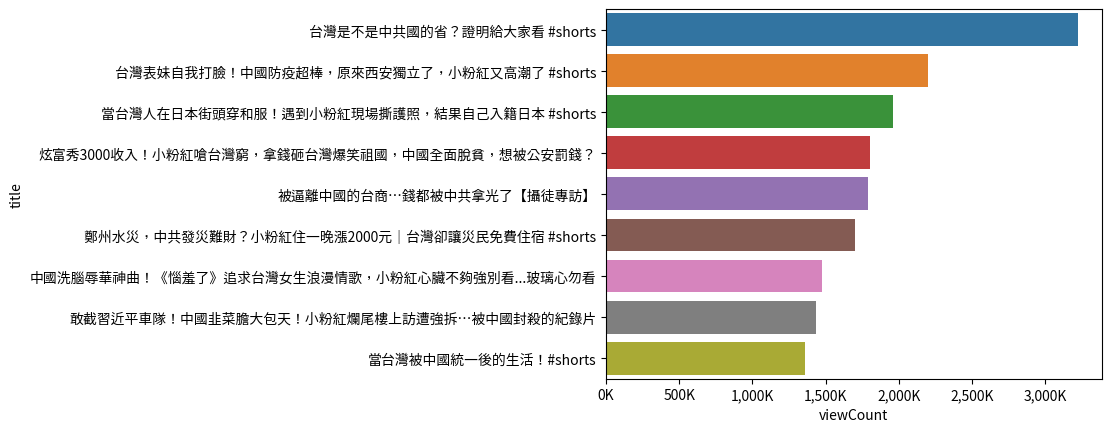

In [23]:
ax = sns.barplot(x = 'viewCount', y = 'title', data = video_df.sort_values('viewCount', ascending=False)[0:9])
# plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## Worst performing videos

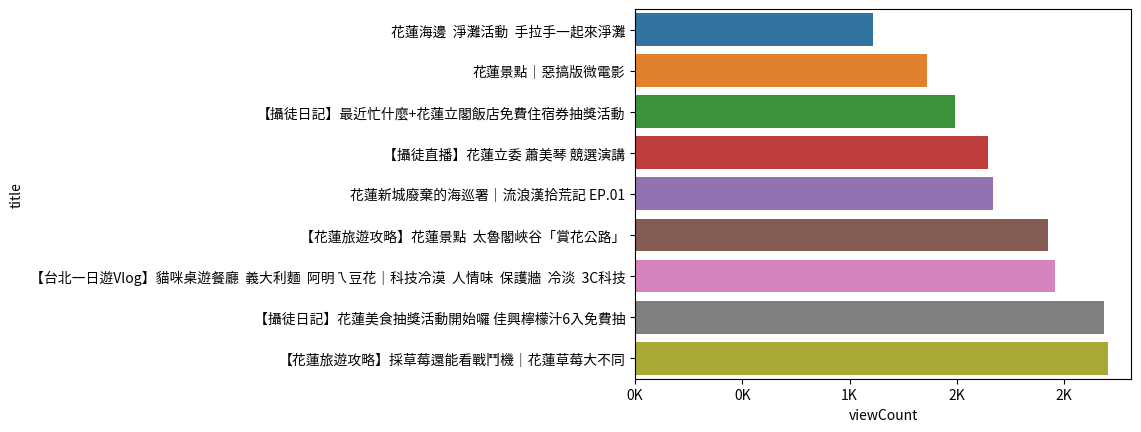

In [24]:
ax = sns.barplot(x = 'viewCount', y = 'title', data = video_df.sort_values('viewCount', ascending=True)[0:9])
# plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## View distribution per video

<Axes: xlabel='channelTitle', ylabel='viewCount'>

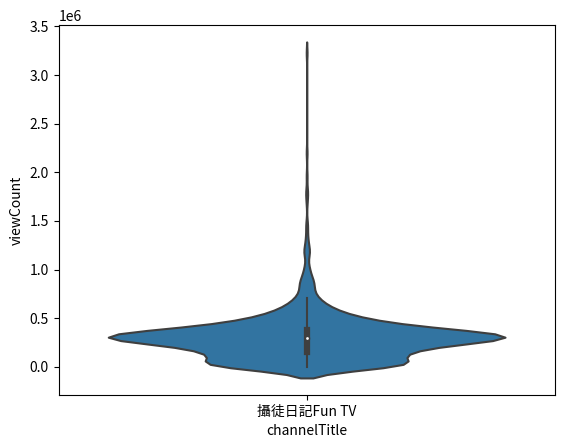

In [25]:
sns.violinplot(x=video_df['channelTitle'],y=video_df['viewCount']) #Violin plot for the channel

## Views vs. likes and comments



<Axes: xlabel='likeCount', ylabel='viewCount'>

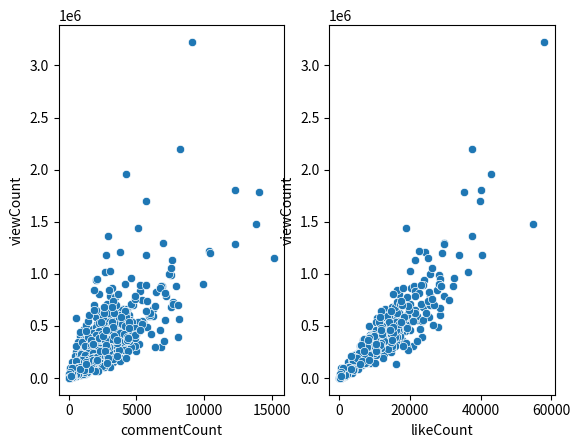

In [26]:
# get the relationship between viewCount and commentCount as well as likeCount
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

## Video duration

<Axes: xlabel='durationSecs', ylabel='Count'>

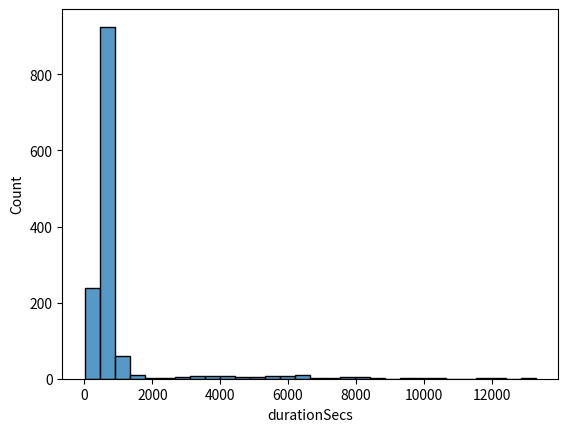

In [27]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

## Wordcloud for video titles in Chinese

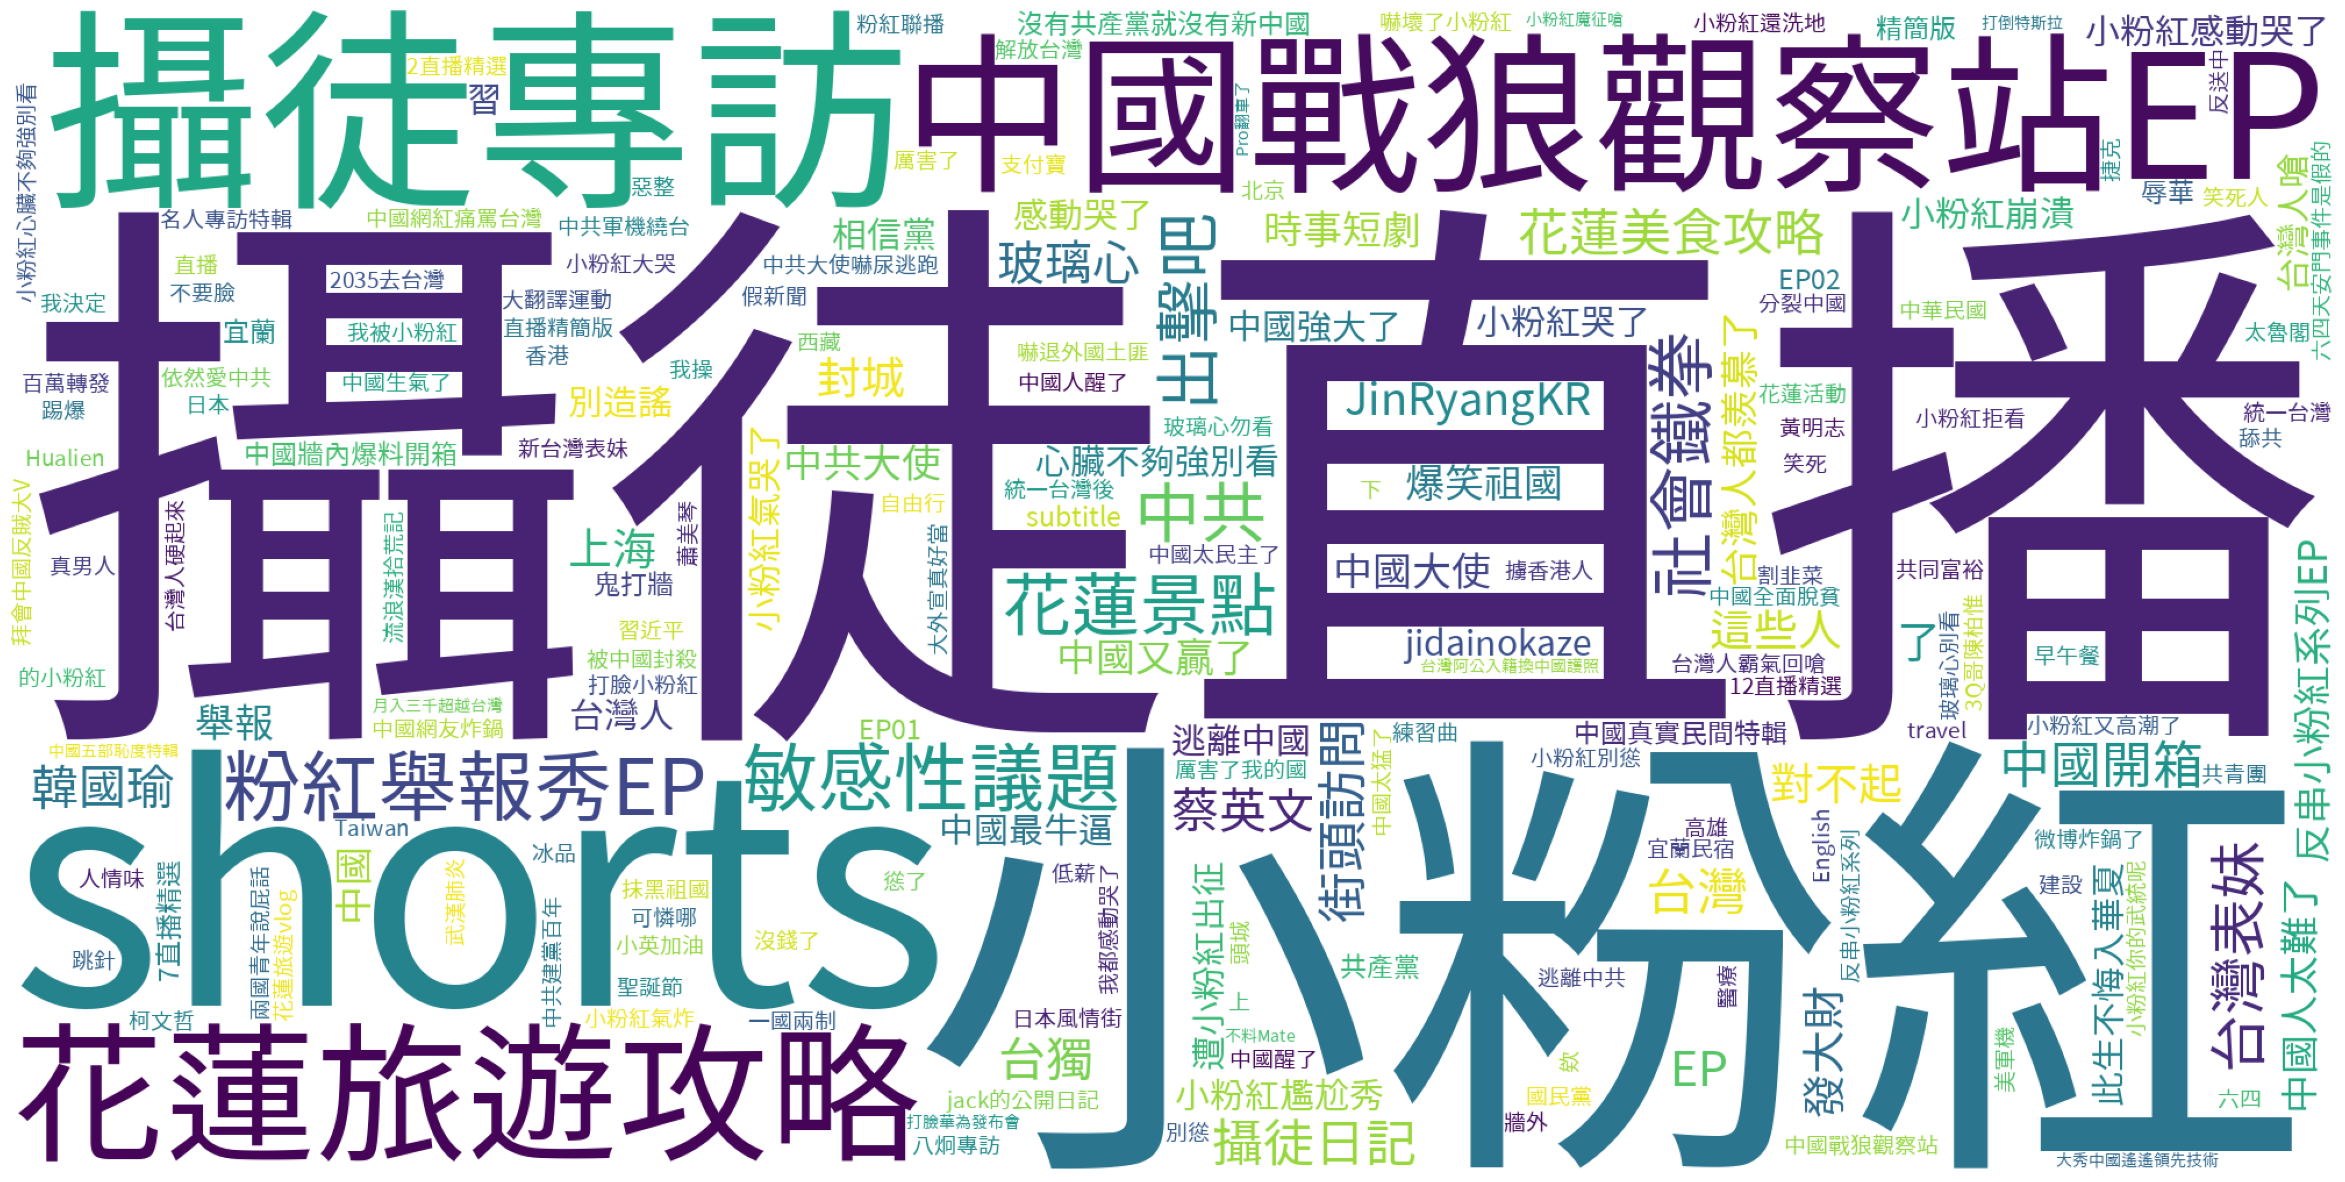

In [28]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='white',
                      colormap='viridis', collocations=False, font_path="TaipeiSansTCBeta-Regular.ttf").generate(all_words_str)
#Because that is Chinese Youtube Channel, we need to change the font_path to support Traditional Chinese
plot_cloud(wordcloud)

## Wordcloud for comments in Chinese

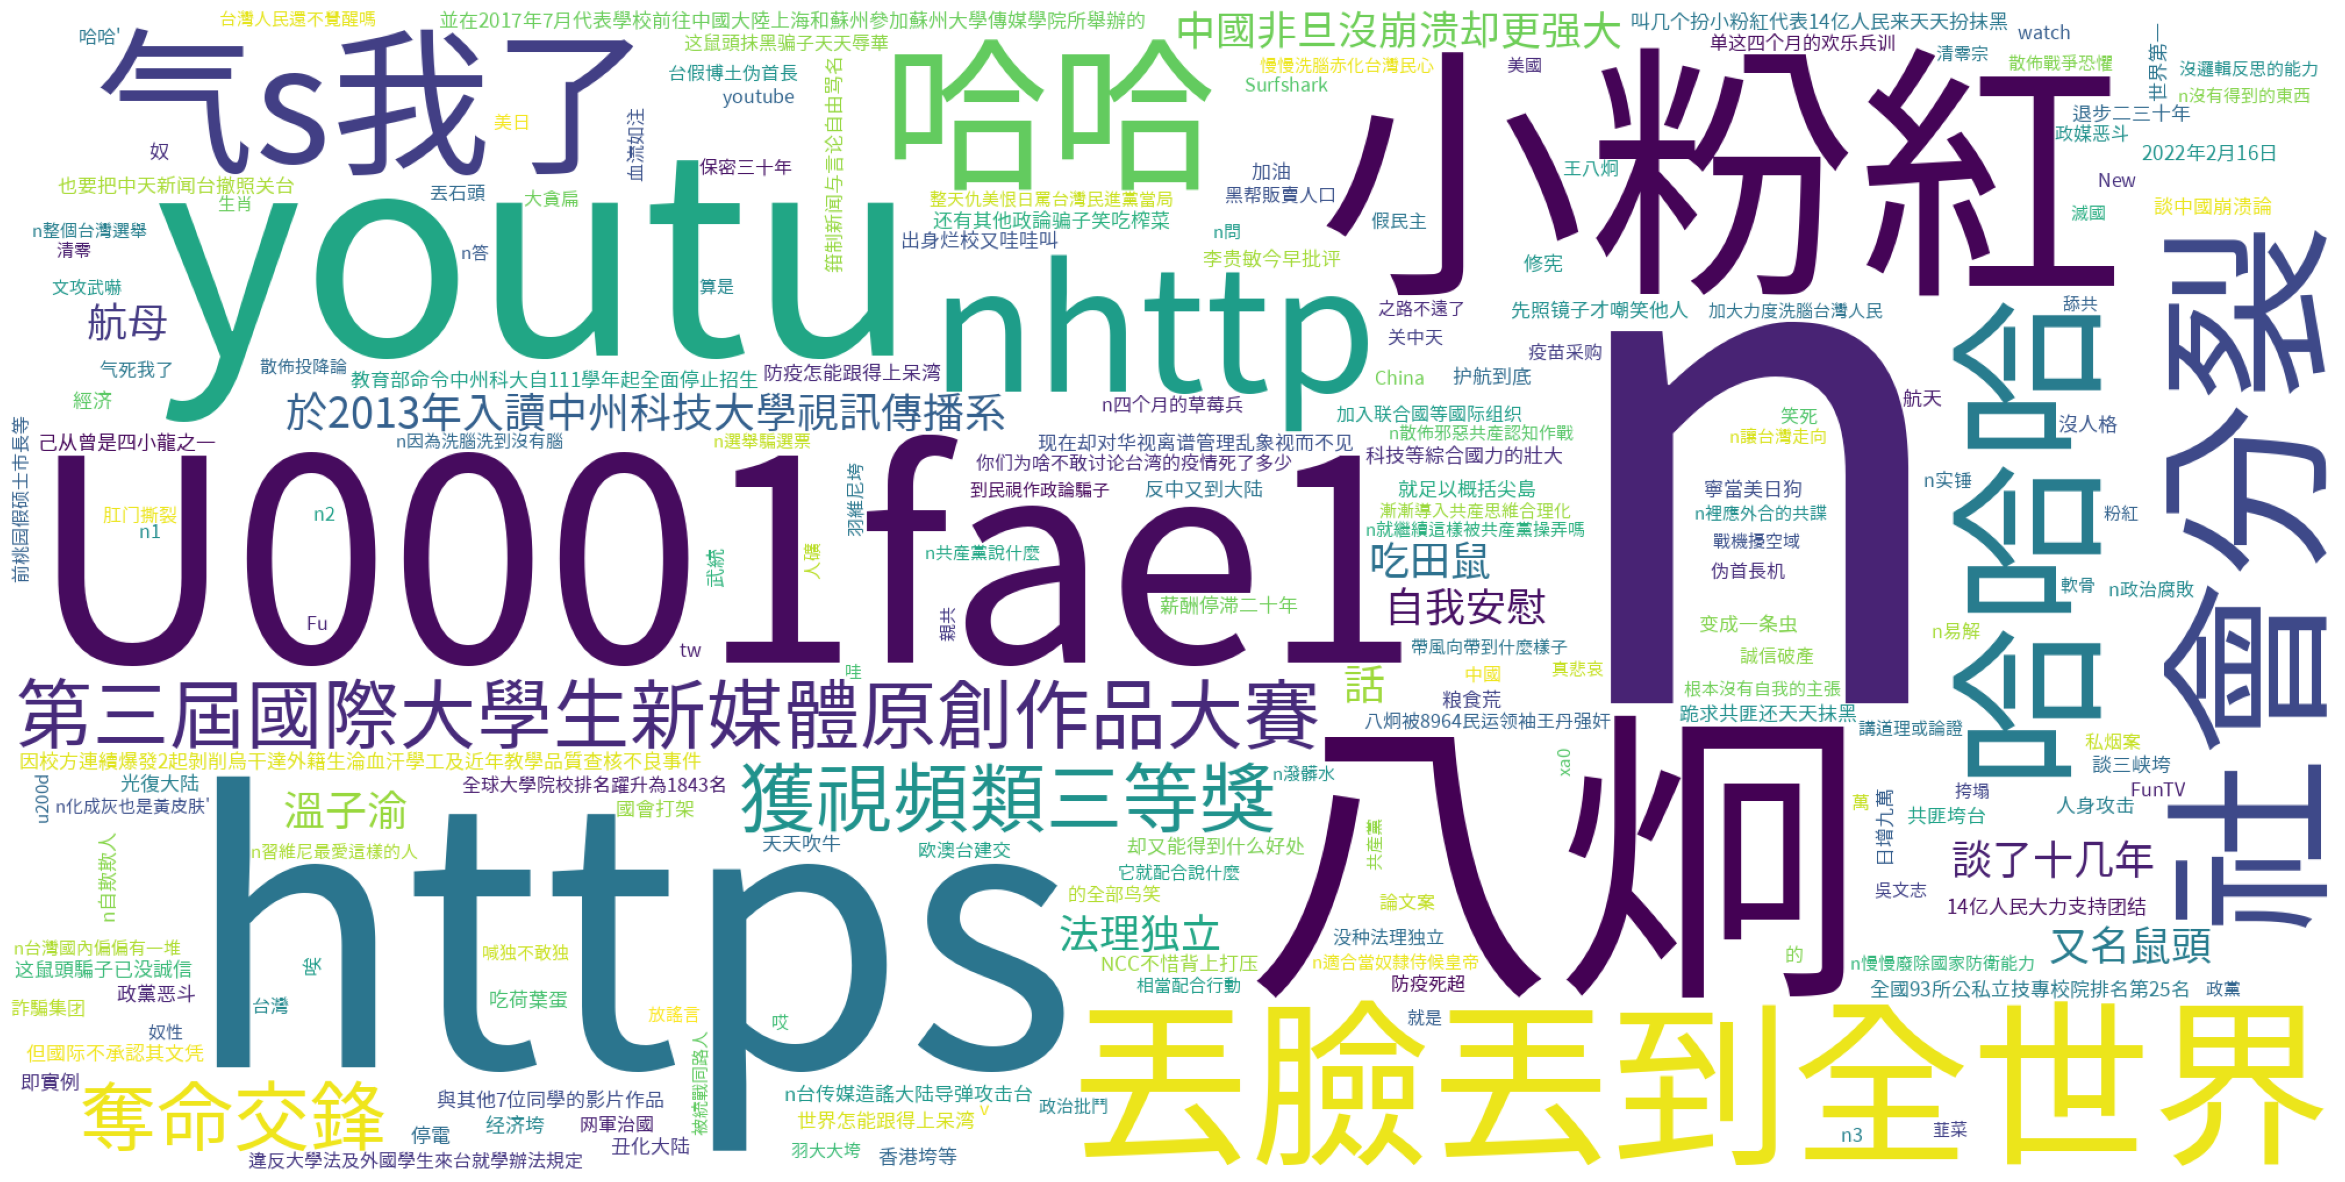

In [29]:
stop_words = set(stopwords.words('english'))
comment_df['comments_no_stopwords'] = comment_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comment_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='white',
                      colormap='viridis', collocations=False, font_path="TaipeiSansTCBeta-Regular.ttf").generate(all_words_str)
plot_cloud(wordcloud)

## Upload schedule

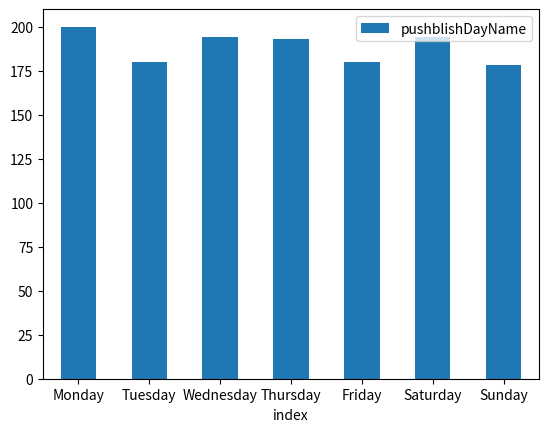

In [30]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)